<a href="https://colab.research.google.com/github/afrago/dl-upna-face-recognition/blob/master/dl_upna_Face_Recognition_01_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Reconocimiento Facial - Mi modelo

El reconocimiento facial es uno de los temas más en auge en estos últimos tiempos.

A pesar de que los sistemas de reconocimiento han alcanzado un cierto nivel de madurez, su éxito se ve limitado por las condiciones impuestas por muchas aplicaciones reales. Por ejemplo, el reconocimiento facial en un ambiente exterior, con cambios de iluminación y/o postura sigue siendo un problema en gran parte sin resolver. En otras palabras, los sistemas actuales están todavía muy lejos de la capacidad del sistema de percepción humana.

En este notebook se implementa un modelo personalizado para realizar el reconocimiento facial a partir de un modelo definidio de manera pesonalizada con **Redes Neuronales Convolucionales (CNN)**.

Para realizar el entrenamiento de la red se hace uso del dataset de **VGGFace2**. 
VGGFace2 es un conjunto de datos de reconocimiento facial a gran escala. Las imágenes se descargan de la Búsqueda de Imágenes de Google y tienen grandes variaciones en la pose, edad, iluminación, etnia y profesión.
Todo el conjunto de datos se divide en conjuntos de entrenamiento (8631 identidades) y de prueba (500 identidades). Accesible desde [aquí](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2), es necesario registrarse.


## Obtener el conjunto de imágenes
Lo primero que vamos a hacer es incorporar el dataset al entorno de Google Colab.

In [0]:
import tarfile, os

# Download a large file from Google Drive. If you use curl/wget, it fails with a large file because of the security warning from Google Drive.
!pip install -U --no-cache-dir gdown --pre
dirName = "/content/data"
if not os.path.exists(dirName):
    os.mkdir(dirName)
    os.chdir(dirName)
    # Download data
    ! gdown "https://drive.google.com/uc?export=download&id=1bjcBciMi0KbbOknXUoWdOLD0yZPCpoWh"
    ! gdown "https://drive.google.com/uc?export=download&id=1g6gxmCNccv13PATm4ppqwRmgKKCdAMcb"
    ! gdown "https://drive.google.com/uc?export=download&id=1pae3P-090tCLH8Cb0UYnXBLu3iIoDhkR"

    !tar -xzvf 'train.tar.gz' 1> null
    !tar -xzvf 'val.tar.gz'  1> null
    !tar -xzvf 'test.tar.gz'  1> null
    print("Directory " , dirName ,  " Created ")
else:    
    print("Directory " , dirName ,  " already exists")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.11.0-cp36-none-any.whl size=9619 sha256=dd5d49eed43cc3f3c84b1dc2d6542fcd2d02a20063faf3bf0aafdf5ae2f9a6fd
  Stored in directory: /tmp/pip-ephem-wheel-cache-njomb9z0/wheels/19/a6/67/ebb80360fc57bb0ddd5da77f57b275084cd8838bf7d5b91685
Successfully built gdown
  Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4
Downloading...
From: https://drive.google.com/uc?export=download&id=1bjcBciMi0KbbOknXUoWdOLD0yZPCpoWh
To: /content/data/train.tar.gz
1.22GB [00:12, 99.5MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1g6gxmCNccv13PATm4ppqwRmgKKCdAMcb
To: /content/data/val.tar.gz
198MB [00:02, 82.9MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1pae3P-090tCLH8Cb0UYnXBLu3iIoDhkR
To: /content/data/test.tar.gz
605MB [00:06,

## Introducción a las Redes Neuronales Convolucionales (CNN)
Se produjo un avance en la creación de modelos para la clasificación de imágenes cuando se descubrió que se podía usar una red neuronal convolucional (CNN) para extraer de forma progresiva niveles cada vez más altos de representaciones del contenido de las imágenes. En lugar de preprocesar los datos para obtener atributos como texturas y formas, una CNN toma, como información de entrada, los datos de los píxeles sin procesar de la imagen y "aprende" a extraer estos atributos y a deducir qué objeto constituyen.

Más información [aquí](https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks)



---


## Implementación de un modelo personalizado de CNN para el reconocimiento facial

### **Parámetros**

In [0]:
BATCH_SIZE = 128
EPOCHS = 10

### **Importaciones**




In [0]:
import keras
from IPython.core.display import Image, display
from keras import layers, models
from keras import optimizers
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
# This is module with image preprocessing utilities
from keras.preprocessing import image

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


### Dataset

En la carpeta data se encuentra el conjunto inicial de imágenes. Dentro de esa carpeta ya están separadas las imágenes en los diversos conjuntos de entrenamiento, validación y test que usaremos, así como las carpetas de cada uno de los personajes con las imágenes originales.

Comprobamos los números:



In [0]:
print('Nº imágenes entrenamiento :', len(os.listdir('/content/data/train')))
print('Nº imágenes validación:', len(os.listdir('/content/data/val')))
print('Nº imágenes test:', len(os.listdir('/content/data/test')))

print('---------')
print('----TRAIN-----')
print('Nº imágenes entrenamiento n000009:', len(os.listdir('/content/data/train/n000009')))
print('Nº imágenes entrenamiento n000029:', len(os.listdir('/content/data/train/n000029')))
print('----VAL-----')
print('Nº imágenes val n000009:', len(os.listdir('/content/data/val/n000009')))
print('Nº imágenes val n000029:', len(os.listdir('/content/data/val/n000029')))
print('-----TEST----')
print('Nº imágenes test n000009:', len(os.listdir('/content/data/test/n000009')))
print('Nº imágenes test n000029:', len(os.listdir('/content/data/test/n000029')))

Nº imágenes entrenamiento : 500
Nº imágenes validación: 500
Nº imágenes test: 500
---------
----TRAIN-----
Nº imágenes entrenamiento n000009: 81
Nº imágenes entrenamiento n000029: 272
----VAL-----
Nº imágenes val n000009: 13
Nº imágenes val n000029: 45
-----TEST----
Nº imágenes test n000009: 42
Nº imágenes test n000029: 137


### Construcción del modelo

Vamos a reutilizar la estructura de Red Convolucional que consta de: una pila alternada de capas layer_conv_2d() (con activación relu) y capas layer_max_pooling_2d().

Como las imágenes de este problema son grandes y el problema es complejo, haremos la red grande con una capa de cada tipo, por lo que aumentaremos la capacidad de la red y a la vez reduciremos el tamaño de salida de la última capa, que habrá que aplanar de forma similar con layer_flatten(). Como comenzamos con imágenes de tamaño 150x150 (es arbitrario), acabaremos con un mapa de características de 7x7 justo como entrada a la capa layer_flatten().

A medida que la profundidad del mapa de características aumente (de 32 a 128), el tamaño del mismo disminuye (de 148x148 a 7x7), un patrón que es habitual en la mayoría de redes CNN.

Como el problema es de clasificación multiclase, acabamos la red con una capa layer_dense() de con tantas unidades como clases tengamos y con activación softmax, que codificará la probabilidad de que la red esté mirando un elemento de cada una de las clases.

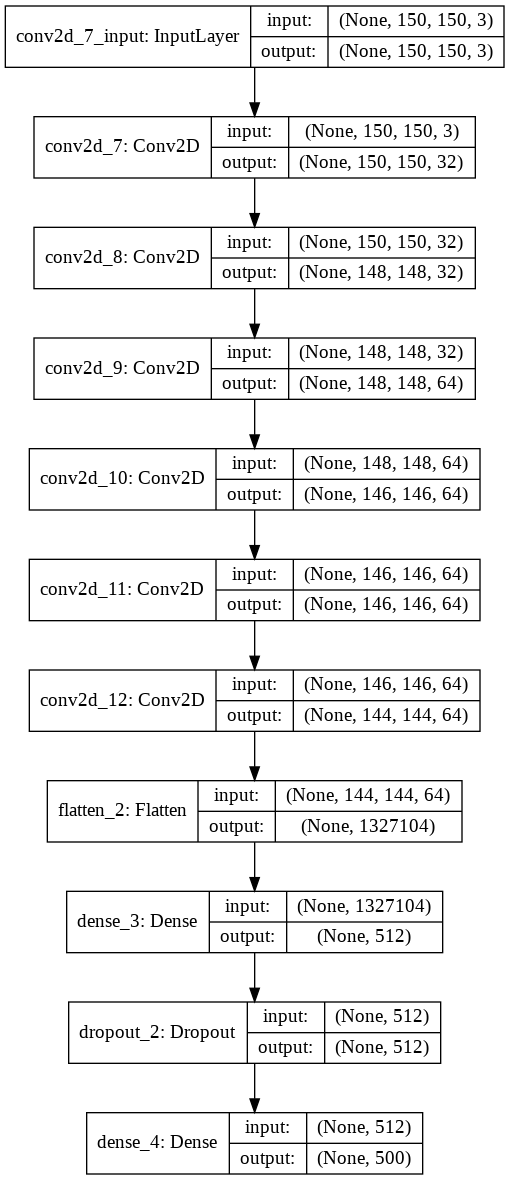

In [0]:
#iniciamos el modelo
CNN = models.Sequential()
#añadimos una capa convolucional con 32 filtros de 3x3
CNN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu',  input_shape=(150, 150, 3) ))
#añadimos otra capa convolucional con 32 filtros de 3x3
CNN.add(layers.Conv2D(32, (3, 3), activation='relu'))

#repetimos todas las capas otra vez
CNN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
CNN.add(layers.Conv2D(64, (3, 3), activation='relu'))

#repetimos todas las capas otra vez
CNN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
CNN.add(layers.Conv2D(64, (3, 3), activation='relu'))

#añadimos una capa para convertir las matrices en un vector
CNN.add(layers.Flatten())
#añadimos una capa con 512 neuronas
CNN.add(layers.Dense(512, activation='relu'))
CNN.add(layers.Dropout(0.5))
#en la última capa tiene que hacer tantas neuronas como clases haya, en este caso 500
CNN.add(layers.Dense(500, activation='softmax'))

plot_model(CNN, to_file='CNNMyFaceRecognizer_plot.png', show_shapes=True, show_layer_names=True)
display(Image(filename='CNNMyFaceRecognizer_plot.png'))

In [0]:
CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 148, 148, 32)      9248      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 148, 148, 64)      18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 146, 146, 64)      36928     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 146, 146, 64)      36928     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 144, 144, 64)      36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1327104)          

### Uso de data augmentation





Con una cantidad inifinita de datos, mostrando todas las posibles opciones existentes, el modelo nunca se sobreajustaría. Data augmentation intenta simuar esta situación ideal generando más datos de entrenamiento a partir de los ejemplos disponibles por medio de la aplicación de transformaciones aleatorias que generan imágenes similares. El objetivo es hacer que nuestro modelo no vea dos veces la misma imagen exacta, lo que ayuda a que generalice mejor.

En Keras esto se puede hacer configurando un conjunto de transformaciones aleatorias para que sean ejecutadas sobre las imágenes que lee el generador image_data_generator(). Veamos un ejemplo que añade más opciones a las ya vistas:

In [0]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Veamos cómo funcionan sobre alguna imagen concreta de nuestro dataset:

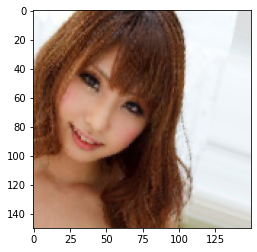

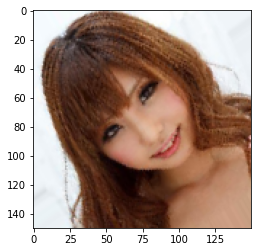

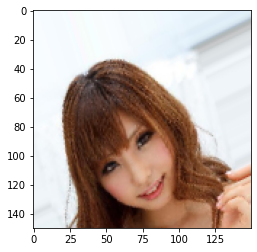

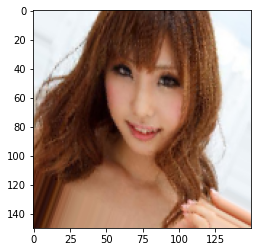

In [0]:
# This is module with image preprocessing utilities
from keras.preprocessing import image


train_n000009_dir = '/content/data/train/n000009'
fnames = [os.path.join(train_n000009_dir, fname) for fname in os.listdir(train_n000009_dir)]

# We pick one image to "augment"
img_path = fnames[1]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

Si entrenamos una red usando esta nueva configuración con datos aumentados, ésta no verá dos veces la misma entrada, aunque evidentemente las entradas estarán altamente correlacionadas porque provienen de unas cuantas imágenes originales. Como consecuencia, no tiene porqué ser suficiente para eliminar el sobreajuste, y por esa razón intercalaremos también una capa intermedia de dropout justo antes de la capa clasificadora densa:


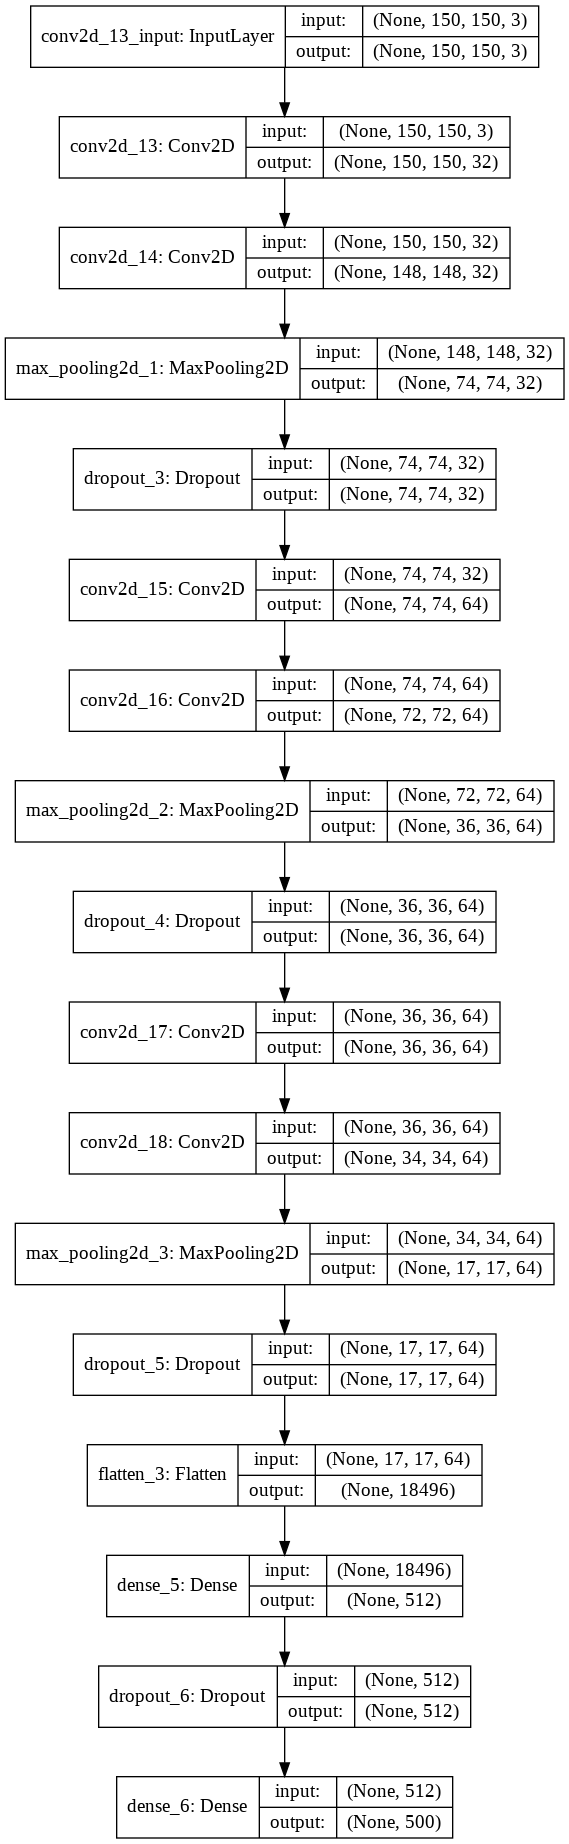

In [0]:
from IPython.core.display import Image, display
from keras import layers
from keras import models
from keras.utils.vis_utils import plot_model
from keras import optimizers


#iniciamos el modelo
CNN_DA = models.Sequential()
#añadimos una capa convolucional con 32 filtros de 3x3
CNN_DA.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu',  input_shape=(150, 150, 3) ))
#añadimos otra capa convolucional con 32 filtros de 3x3
CNN_DA.add(layers.Conv2D(32, (3, 3), activation='relu'))
#añadimos una capa de pooling de 2x2
CNN_DA.add(layers.MaxPooling2D(pool_size=(2, 2)))
#este dropout desactiva el 25% de las conexiones entre las neuronas, lo cual mejora los resultados
CNN_DA.add(Dropout(0.25))

#repetimos todas las capas otra vez
CNN_DA.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
CNN_DA.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN_DA.add(layers.MaxPooling2D(pool_size=(2, 2)))
CNN_DA.add(layers.Dropout(0.25))

#repetimos todas las capas otra vez
CNN_DA.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
CNN_DA.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN_DA.add(layers.MaxPooling2D(pool_size=(2, 2)))
CNN_DA.add(layers.Dropout(0.25))

#añadimos una capa para convertir las matrices en un vector
CNN_DA.add(layers.Flatten())
#añadimos una capa con 512 neuronas
CNN_DA.add(layers.Dense(512, activation='relu'))
CNN_DA.add(layers.Dropout(0.5))
#en la última capa tiene que hacer tantas neuronas como clases haya, en este caso 500
CNN_DA.add(layers.Dense(500, activation='softmax'))


#compilamos el modelo
CNN_DA.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

plot_model(CNN_DA, to_file='CNNFaceRecognition_plot.png', show_shapes=True, show_layer_names=True)
display(Image(filename='CNNFaceRecognition_plot.png'))

In [0]:
CNN_DA.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 148, 148, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 74, 74, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)       

### Preprocesado de los datos

Como ya sabemos, los datos deben ser formateados para ser convertidos en tensores de punto flotante para alimentar la red, pero lo que tenemos son ficheros JPEG, así que los pasos para convertirlos son:

Leer los ficheros de imágenes.
Decodificar JPEG en una matriz de RGB.
Convertir la matriz en tensores de punto flotante.
Re-escalar los valores de [0,255] a [0, 1].
Aunque puede parece algo tedioso, Keras proporciona utilidades para llevar a cabo este tipo de acciones, que son muy comunes. En particular, incluye la función image_data_generator(), que automáticamente convierte ficheros de imágenes en tensores preprocesados.

NOTA: Las funciones anteriores necesitan la librería Pillow de Python.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        '/content/data/train',
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=BATCH_SIZE,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        '/content/data/val',
        target_size=(150, 150),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 101434 images belonging to 500 classes.
Found 16715 images belonging to 500 classes.


Este proceso ha generado un paquete de imágenes de tamaño (128, 150, 150, 3) (128 imágenes de 150x150 con 3 canales) y un paquete de etiquetas de tamaño (128,500).

In [0]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (128, 150, 150, 3)
labels batch shape: (128, 500)


Se debe tener en cuenta que el generador crea los batches de imágenes indefinidamente, haciendo un loop sobre el conjunto de imágenes de la carpeta. En realidad, estas imágenes no se procesan previamente, sino que se crea un batch cuando el entrenamiento lo requiere. Esta característica hará que el proceso de entrenamiento tenga ligeras diferencias a las vistas anteriormente.

Durante el entrenamiento debemos usar el generador anterior, y para eso Keras proporciona una variante de la función fit llamada fit_generator, que espera como primer argumento un generador que producirá batches de entradas y etiquetas de forma indefinida, al estilo del que hemos escrito antes.

Como los datos se generan sin fin, el generador necesita saber cuántas muestras tomar para cada epoch, para lo que hace uso del argumento steps_per_epoch: tras haber tomado steps_per_epoch batches del generador (es decir, tras haber ejecutado steps_per_epoch pasos del optimizador) el proceso de entrenamiento pasará a la siguiente epoch.

Cuando se usa fit_generator, se puede pasar un argumento validation_data tal y como se hace con fit. Este argumento puede ser un generador o una lista de arrays. Si pasas un generador, funcionará indefinidamente, por lo que tendrás que especificar también el argumento validation_steps, que indica cuántos batches crear para la evaluación.

In [0]:
entrenamiento = CNN_DA.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=50
      )

Epoch 1/10
100/100 [==============================] - 1579s 16s/step - loss: 6.1981 - accuracy: 0.0035 - val_loss: 6.1934 - val_accuracy: 0.0030
Epoch 2/10
100/100 [==============================] - 1569s 16s/step - loss: 6.1774 - accuracy: 0.0033 - val_loss: 6.2053 - val_accuracy: 0.0053
Epoch 3/10
100/100 [==============================] - 1570s 16s/step - loss: 6.1624 - accuracy: 0.0049 - val_loss: 6.0959 - val_accuracy: 0.0063
Epoch 4/10
100/100 [==============================] - 1569s 16s/step - loss: 5.9893 - accuracy: 0.0113 - val_loss: 5.6891 - val_accuracy: 0.0228
Epoch 5/10
100/100 [==============================] - 1564s 16s/step - loss: 5.7343 - accuracy: 0.0189 - val_loss: 5.6021 - val_accuracy: 0.0362
Epoch 6/10
100/100 [==============================] - 1573s 16s/step - loss: 5.5156 - accuracy: 0.0298 - val_loss: 5.2310 - val_accuracy: 0.0481
Epoch 7/10
100/100 [==============================] - 1575s 16s/step - loss: 5.3701 - accuracy: 0.0350 - val_loss: 5.1906 - val_ac

Es una buena práctica grabar el modelo tras el entrenamiento, sobre todo si puede consumir un tiempo excesivo:

In [0]:
CNN_DA.save('my_face_recognizer_2.h5')

Representemos la pérdida y precisión experimentada en el proceso de entrenamiento para poder analizar cómo se comporta el modelo:

{'val_loss': [6.193406581878662, 6.205348491668701, 6.095895767211914, 5.689082145690918, 5.602094650268555, 5.230972766876221, 5.190564155578613, 4.883781909942627, 4.776271820068359, 4.787548542022705], 'val_accuracy': [0.002968749962747097, 0.0053125000558793545, 0.006302190013229847, 0.022812500596046448, 0.036249998956918716, 0.048054199665784836, 0.05937499925494194, 0.07200252264738083, 0.09046874940395355, 0.10093750059604645], 'loss': [6.198085975646973, 6.177441372871399, 6.162439641952514, 5.989267740249634, 5.734336282845472, 5.515624485015869, 5.3701215267181395, 5.210808124542236, 5.04309380531311, 4.914230589866638], 'accuracy': [0.003515625, 0.00328125, 0.004921875, 0.01125, 0.018931657, 0.029765625, 0.035, 0.044453125, 0.059296876, 0.07039063]}


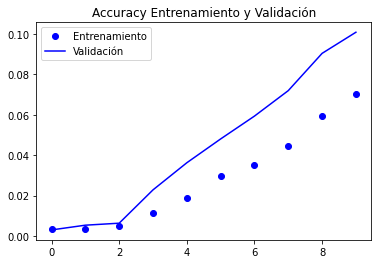

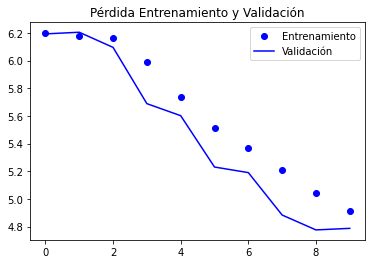

In [0]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

print(entrenamiento.history)

ent_acc = entrenamiento.history['accuracy']
val_acc = entrenamiento.history['val_accuracy']
ent_loss = entrenamiento.history['loss']
val_loss = entrenamiento.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Validación')
plt.title('Accuracy Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'bo', label='Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.title('Pérdida Entrenamiento y Validación')
plt.legend()

plt.show()

Podemos ver como llegamos a una precisión de un 10%, por lo que la técnina de Redes Neuronales Convolucionales por si sola no es suficiente para realizar Reconocimiento Facial.


